In [95]:
import numpy as np
import healpy as hp
import math
import matplotlib.pyplot as plt
import dynesty
%matplotlib inline

from astropy.io import fits
from statistics import mean
from scipy.optimize import curve_fit
from astropy_healpix import HEALPix
from tqdm import tqdm
from scipy.optimize import fsolve
from scipy.optimize import minimize
from dynesty import utils as dyfunc
from dynesty import utils as dyplot
%run Function_defs.ipynb

# HEALPY Math (Unimportant) vvv

MATH\
$n=\sqrt{\frac{len(array)}{12}}$\
l=total length of chain= $2n+1$ [(4,8,12,16,16,16,16,16,16,16,16,16,12,8,4); l=9]\
N=total number of rows=(4n-1) [above,n=4,#rows=15]\
S=total sum=$12n^2$\
lt=thickness of each row in degrees=180/N (above, N=15, lt=180/15=12)\
s=number of rows from lat=0= ROUND UP: s=desired region cut out/lt\
index=$len(array)-(2n(n-1)+4n(n-s))$\ <-- iff s<=n\
th=thickness=(2s+1)*(4n)

Real stuff vvv

# Data

fornengo files

"lambda_DRAO_22MHz_1_256.fits",22,"G",False\
"MAIPU_MU_1_64.fits",45,"G",False\
"haslam408_dsds_Remazeilles2014.fits",408,"G",False\
"Dwingeloo_Kelvins_1_256.fits",820,"G",False\
"STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,"G",False\
"lambda_23de_hea.fits",2326,"C",False\

LWA files

"LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,"C",False\

ARCADE files

"ARCADE Files/arc2_3150_v19.fits",3150,"G",True\
"ARCADE Files/arc2_3410_v19.fits",3410,"G",True\
"ARCADE Files/arc2_8330_v19.fits",8330,"G",True\
"ARCADE Files/arc2_9720_v19.fits",9720,"G",True\
"ARCADE Files/arc2_10490_v19.fits",10490,"G",True\
See pg 2 as to why we dont include vvv\
"ARCADE Files/arc2_7970_v19.fits",7970,"G",True\
"ARCADE Files/arc2_29500_v19.fits",29500,"G",True\
"ARCADE Files/arc2_31000_v19.fits",31000,"G",True\
"ARCADE Files/arc2_88200_v19.fits",88200,"G",True\
"ARCADE Files/arc2_89800_v19.fits",89800,"G",True\

In [90]:
files=[#["lambda_DRAO_22MHz_1_256.fits",22,"G",False,[3000,5,5000]],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-35.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-38.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-40.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-45.fits"],
       #["MAIPU_MU_1_64.fits",45,"G",False,[300,10,544]],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-50.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-60.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-70.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-74.fits"],
       #["LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-80.fits"],
       #["haslam408_dsds_Remazeilles2014.fits",408,"G",False,[1.2,10,3]],
       #["Dwingeloo_Kelvins_1_256.fits",820,"G",False,[0.5,6,0.6]],
       #["STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,"G",False,[0.017,5,0.5]],
       #["lambda_23de_hea.fits",2326,"C",False,[0.03,5,0.08]],
       ["ARCADE Files/arc2_3150_v19.fits",3150,"G",True,[0.005,0,0.00749]],
       ["ARCADE Files/arc2_3410_v19.fits",3410,"G",True,[0.0047,0,0.00605]],
       ["ARCADE Files/arc2_7970_v19.fits",7970,"G",True,[0.0077,0,0.0118]],
       ["ARCADE Files/arc2_8330_v19.fits",8330,"G",True,[0.0086,0,0.01348]],
       ["ARCADE Files/arc2_9720_v19.fits",9720,"G",True,[0.0039,0,0.00451]],
       ["ARCADE Files/arc2_10490_v19.fits",10490,"G",True,[0.0041,0,0.00438]],
       #["ARCADE Files/arc2_29500_v19.fits",29500,"G",True,[0.0273,0,0.153]],
       #["ARCADE Files/arc2_31000_v19.fits",31000,"G",True,[0.0135,0,0.075]],
       #["ARCADE Files/arc2_88200_v19.fits",88200,"G",True,[0.0138,0,0.0354]],
       #["ARCADE Files/arc2_89800_v19.fits",89800,"G",True,[0.0069,0,0.0207]]
      ]

# files[i][0]=file name
# files[i][1]=Mhz
# files[i][2]=coords
# files[i][3]=In thermal temp?
# files[i][4]=Uncertainty map, or [rms, calibration error, zero-level/systematic]

# Method Used by Arcade to find $T_{G}$:
- Not many data points, pole data is clumped together

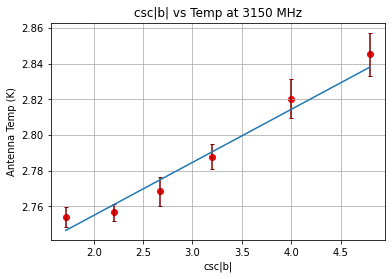

T_extra at 3150MHz is 2.69564 plus/minus 0.00909
T_g at 3150MHz is 0.02968 plus/minus 0.00337


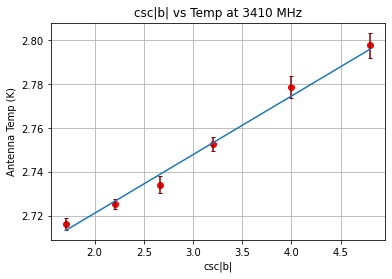

T_extra at 3410MHz is 2.66782 plus/minus 0.00428
T_g at 3410MHz is 0.02671 plus/minus 0.00159


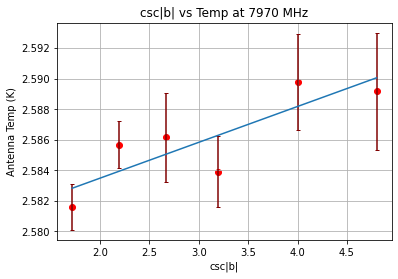

T_extra at 7970MHz is 2.57878 plus/minus 0.00267
T_g at 7970MHz is 0.00235 plus/minus 0.00101


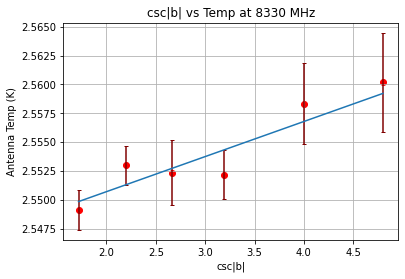

T_extra at 8330MHz is 2.54461 plus/minus 0.00299
T_g at 8330MHz is 0.00304 plus/minus 0.00111


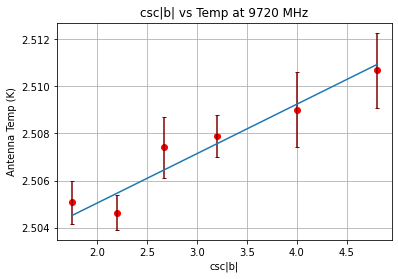

T_extra at 9720MHz is 2.50086 plus/minus 0.00137
T_g at 9720MHz is 0.00209 plus/minus 0.00048


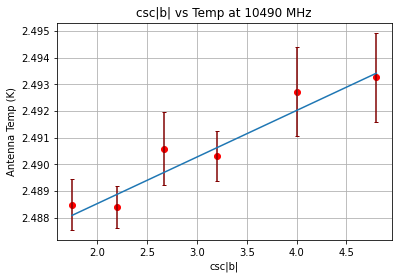

T_extra at 10490MHz is 2.48503 plus/minus 0.00144
T_g at 10490MHz is 0.00175 plus/minus 0.00051


In [96]:
c_ARCADE=[]
freq_ARCADE=[]
T_g_ARCADE=[]
c_unc_ARCADE=[]
T_g_unc_ARCADE=[]
Region="North"
for file in files:
    c,c_unc,T_g,T_g_unc,freq=cscb_Temp_fit_ARCADE(file,Region,True)
    c_ARCADE.append(c)
    T_g_ARCADE.append(T_g)
    freq_ARCADE.append(freq)
    c_unc_ARCADE.append(c_unc)
    T_g_unc_ARCADE.append(T_g_unc)


In [91]:
ndim = 2
def loglike(c):
    return -0.5 * (np.sum((T_g_ARCADE-c[0]*(np.array(freq_ARCADE)/310)**(c[1]))**2/np.array(T_g_unc_ARCADE)**2))
coeffs,coeffs_err=DynestyFit(2,loglike,[[20,0],[0,-5]],False)

3846it [00:06, 626.62it/s, +500 | bound: 6 | nc: 1 | ncall: 21991 | eff(%): 20.222 | loglstar:   -inf < -0.433 <    inf | logz: -7.275 +/-  0.108 | dlogz:  0.001 >  0.509]  
15232it [00:25, 597.71it/s, batch: 8 | bound: 5 | nc: 1 | ncall: 38304 | eff(%): 39.766 | loglstar: -5.640 < -0.433 < -0.816 | logz: -7.179 +/-  0.061 | stop:  0.886]                  


0.10874582958974946


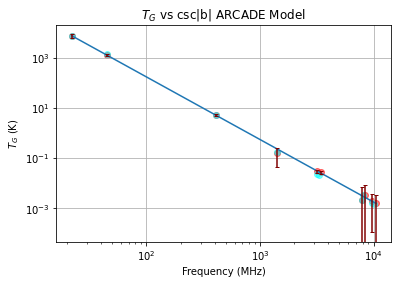

Beta=-2.4995 pm 0.0276 T_gal=10.5524 pm 0.6115


In [92]:
#ARCADE's vals [freq,T_G] taken from webplotdigitizer
ARCADE_values=np.array([[0.022, 7916.466442719286],[0.0449911960441924, 1477.608608244475],[0.40821171019251795, 5.423909275261779],[1.4187602660051026, 0.18211559182524475],[3.1830482133930253, 0.024842402354320066],[3.292042817918938, 0.02223972977416826],[7.944768276910435, 0.00217662549410399],[8.125112950295586, 0.0035161015953122823],[9.723324608998443, 0.0016505302870564848],[10.169769956773699, 0.001477608608244478]]).transpose()

plt.plot(freq_ARCADE,coeffs[0]*(np.array(freq_ARCADE)/310)**(coeffs[1]))    
plt.errorbar(x=freq_ARCADE,y=T_g_ARCADE,yerr=T_g_unc_ARCADE,fmt="none",color="maroon",capsize=2)
plt.scatter((freq_ARCADE),(T_g_ARCADE),color="red",alpha=0.5)
plt.scatter((ARCADE_values[0])*1000,(ARCADE_values[1]),color="cyan",alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| ARCADE Model")
plt.grid()
plt.show()
print("Beta=%.4f pm %.4f"% (coeffs[1],coeffs_err[1]),"T_gal=%.4f pm %.4f"% (coeffs[0],coeffs_err[0]))

# Holistic Method:
- Plots each Temp according to its own csc|b|, does not average and thus favors latitudes with more points (center)

28.907417099375575
90934871.37718453
1299456
{1.0000457784627592, 1.0001271727463719, 1.0019377993173748, 1.006822403703481, 1.0088372289918581, 1.0144943988359074, 1.0171040872625312, 1.0244495305882921, 1.1361619687279232, 1.0424726700079932, 1.202613099752881, 1.3837277841022058, 1.8506024096385545, 1.9948051948051955, 2.0263852242744065, 3.0, 4.0, 1.105539279910481, 1.2322522316427114, 4.711656441717793, 4.891719745222929, 1.4715396648379202, 3.475113122171948, 3.588785046728973, 3.657142857142859, 3.9587628865979387, 1.1371723388011012, 1.1986264519265795, 1.2945318788549194, 1.3345279791480003, 1.7902097902097902, 1.000249289017547, 1.2413081188412614, 1.3681075514237202, 2.000000000000001, 2.042553191489362, 2.313253012048194, 2.89811320754717, 1.001303780964798, 1.0266964149334907, 1.108114239336737, 1.1234807056040321, 1.2618931478010833, 1.7695852534562218, 5.052631578947371, 1.010641893411433, 1.01650460213297, 1.0186520765978613, 1.0230102908254124, 1.4579133629822976, 1.69

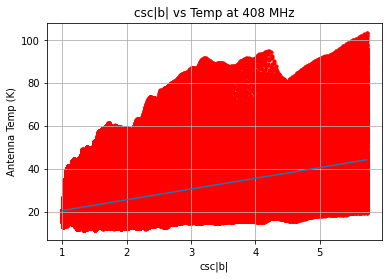

T_extra at 408MHz is 15.48266 plus/minus 3.00006
T_g at 408MHz is 5.01506 plus/minus 0.00833
90
{1.5000000000000004, 1.7142857142857149, 2.000000000000001, 1.6000000000000003, 1.8461538461538467, 2.181818181818182, 2.3999999999999995, 2.666666666666667, 3.0, 3.4285714285714284, 4.0, 4.8000000000000025}


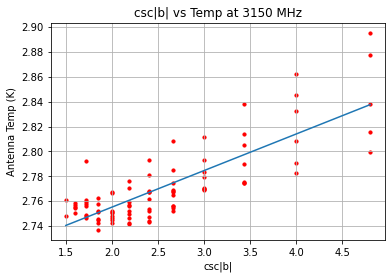

T_extra at 3150MHz is 2.69621 plus/minus 0.00163
T_g at 3150MHz is 0.02946 plus/minus 0.00060


In [222]:
c_hol=[]
freq_hol=[]
T_g_hol=[]
c_unc_hol=[]
T_g_unc_hol=[]
Region="North"
for file in files:
    c,c_unc,T_g,T_g_unc,freq=cscb_Temp_fit_hol(file,Region,True)
    c_hol.append(c)
    c_unc_hol.append(c_unc)
    T_g_hol.append(T_g)
    T_g_unc_hol.append(T_g_unc)
    freq_hol.append(freq)


In [ ]:
ndim = 2
def loglike(c):
    return -0.5 * (np.sum((T_g_hol-c[0]*(np.array(freq_hol)/310)**(c[1]))**2/np.array(T_g_unc_hol)**2))
coeffs,coeffs_err=DynestyFit(2,loglike,[[20,0],[0,-5]],False)

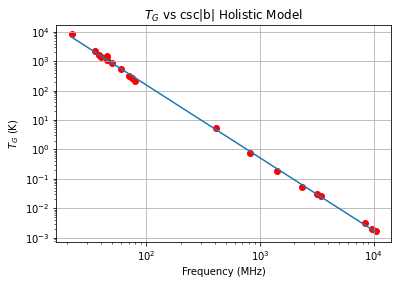

Beta=-2.4751 T_gal=7.1405


In [23]:
#ARCADE's vals [freq,T_G] taken from webplotdigitizer
ARCADE_values=np.array([[0.022, 7916.466442719286],[0.0449911960441924, 1477.608608244475],[0.40821171019251795, 5.423909275261779],[1.4187602660051026, 0.18211559182524475],[3.1830482133930253, 0.024842402354320066],[3.292042817918938, 0.02223972977416826],[7.944768276910435, 0.00217662549410399],[8.125112950295586, 0.0035161015953122823],[9.723324608998443, 0.0016505302870564848],[10.169769956773699, 0.001477608608244478]]).transpose()

plt.plot(freq_hol,coeffs[0]*(np.array(freq_hol)/310)**(coeffs[1]))    
plt.errorbar(x=freq_hol,y=T_g_hol,yerr=T_g_unc_hol,fmt="none",color="maroon",capsize=2)
plt.scatter((freq_hol),(T_g_hol),color="red",alpha=0.5)
plt.scatter((ARCADE_values[0])*1000,(ARCADE_values[1]),color="cyan",alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| ARCADE Model")
plt.grid()
plt.show()
print("Beta=%.4f pm %.4f"% (coeffs[1],coeffs_err[1]),"T_gal=%.4f pm %.4f"% (coeffs[0],coeffs_err[0]))

# Holistic Mean Method
- bin by EACH UNIQUE (up to the hundredths) csc|b| value-- this means that csc|b| towards the poles, with few data points, are as equal as the central ones; top heavy

139.4354466653491


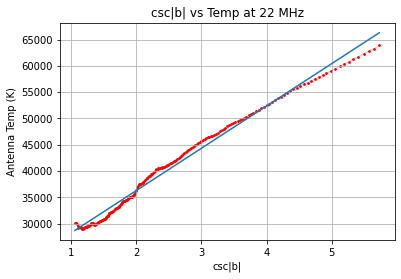

T_extra at 22MHz is 20154.70751 plus/minus 5002.41893
T_g at 22MHz is 8053.26332 plus/minus 58.42873


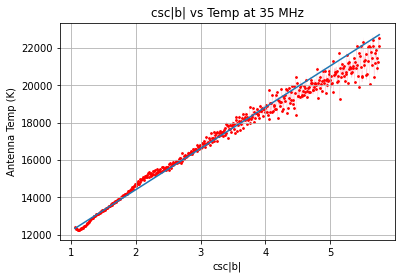

T_extra at 35MHz is 9987.63691 plus/minus 7.95578
T_g at 35MHz is 2209.73804 plus/minus 3.90784


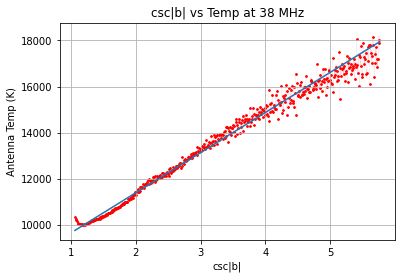

T_extra at 38MHz is 7924.34933 plus/minus 4.88971
T_g at 38MHz is 1737.65511 plus/minus 2.28856


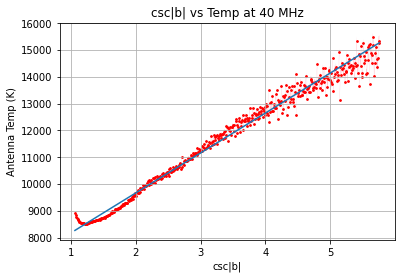

T_extra at 40MHz is 6686.43566 plus/minus 4.72762
T_g at 40MHz is 1490.45217 plus/minus 2.16755


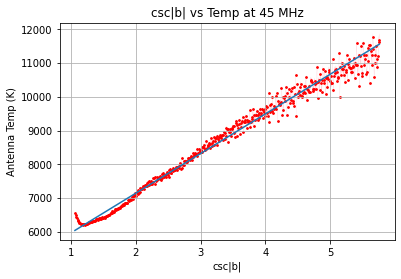

T_extra at 45MHz is 4794.30866 plus/minus 3.86093
T_g at 45MHz is 1174.84100 plus/minus 1.69907
213.7100465469498


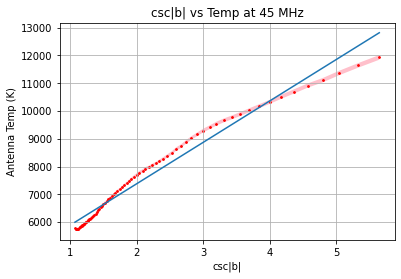

T_extra at 45MHz is 4402.92187 plus/minus 548.80437
T_g at 45MHz is 1489.42896 plus/minus 30.10289


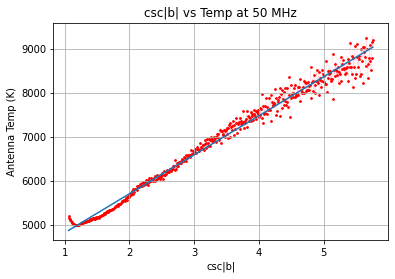

T_extra at 50MHz is 3931.40568 plus/minus 3.13768
T_g at 50MHz is 886.02473 plus/minus 1.39334


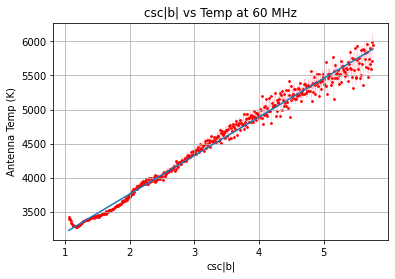

T_extra at 60MHz is 2629.49999 plus/minus 3.44621
T_g at 60MHz is 565.71891 plus/minus 1.59242


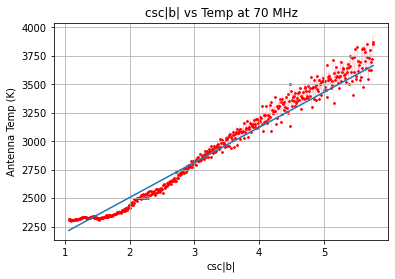

T_extra at 70MHz is 1888.87422 plus/minus 1.97928
T_g at 70MHz is 308.32842 plus/minus 0.87632


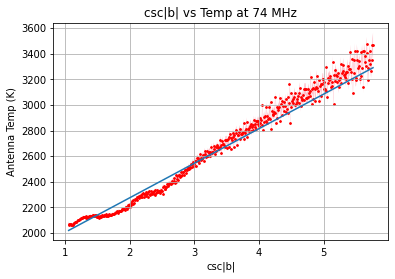

T_extra at 74MHz is 1733.31898 plus/minus 1.75871
T_g at 74MHz is 270.32521 plus/minus 0.81735


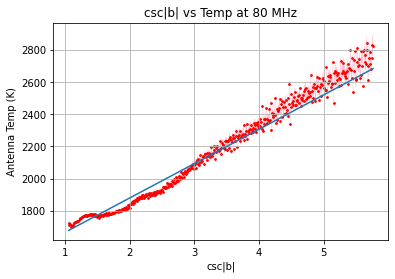

T_extra at 80MHz is 1449.20204 plus/minus 1.57022
T_g at 80MHz is 214.52035 plus/minus 0.72288
326.62738198517906


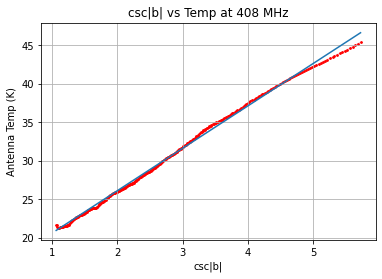

T_extra at 408MHz is 15.13659 plus/minus 3.00043
T_g at 408MHz is 5.50034 plus/minus 0.01699
37.88620907296521


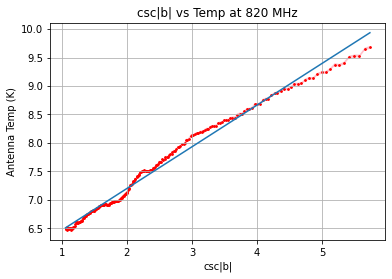

T_extra at 820MHz is 5.72796 plus/minus 0.60018
T_g at 820MHz is 0.73444 plus/minus 0.00567
9409.587665525107


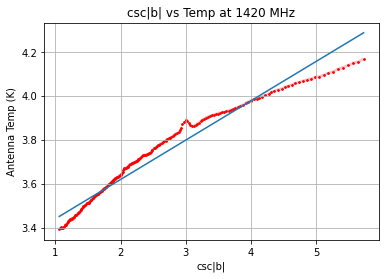

T_extra at 1420MHz is 3.26091 plus/minus 0.50005
T_g at 1420MHz is 0.17945 plus/minus 0.00258
96.1552318652357


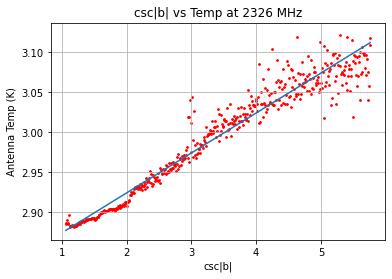

T_extra at 2326MHz is 2.82438 plus/minus 0.08003
T_g at 2326MHz is 0.04992 plus/minus 0.00059


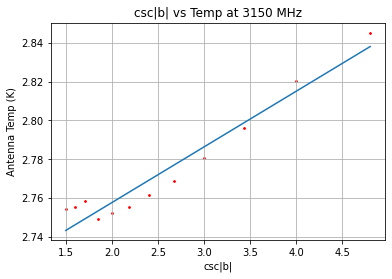

T_extra at 3150MHz is 2.70015 plus/minus 0.00709
T_g at 3150MHz is 0.02874 plus/minus 0.00255


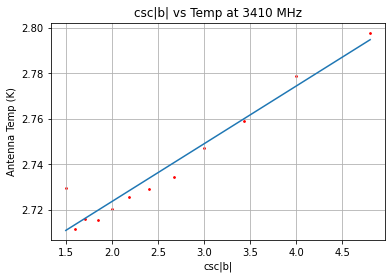

T_extra at 3410MHz is 2.67271 plus/minus 0.00597
T_g at 3410MHz is 0.02543 plus/minus 0.00215


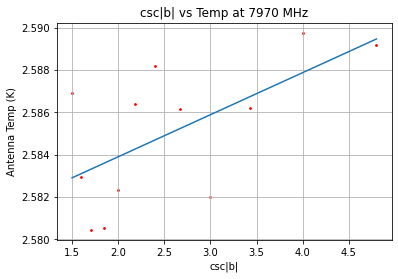

T_extra at 7970MHz is 2.57992 plus/minus 0.01056
T_g at 7970MHz is 0.00199 plus/minus 0.00380


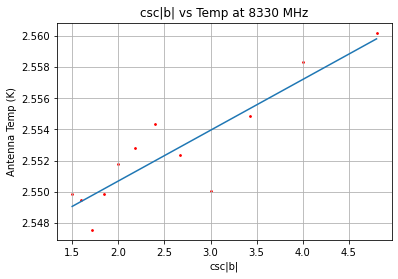

T_extra at 8330MHz is 2.54418 plus/minus 0.01202
T_g at 8330MHz is 0.00325 plus/minus 0.00433


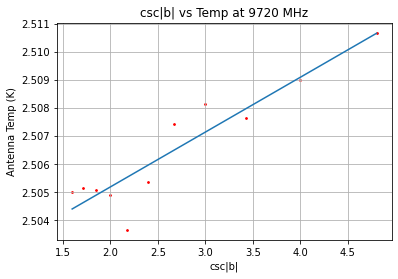

T_extra at 9720MHz is 2.50127 plus/minus 0.00479
T_g at 9720MHz is 0.00196 plus/minus 0.00167


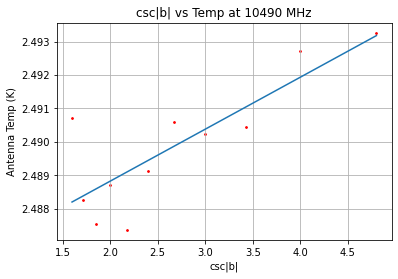

T_extra at 10490MHz is 2.48570 plus/minus 0.00476
T_g at 10490MHz is 0.00156 plus/minus 0.00166


In [205]:
c_hol_mean=[]
freq_hol_mean=[]
T_g_hol_mean=[]
c_unc_hol_mean=[]
T_g_unc_hol_mean=[]
Region="North"
for file in files:
    c,c_unc,T_g,T_g_unc,freq=cscb_Temp_fit_hol_mean(file,Region,True)
    c_hol_mean.append(c)
    c_unc_hol_mean.append(c_unc)
    T_g_hol_mean.append(T_g)
    T_g_unc_hol_mean.append(T_g_unc)
    freq_hol_mean.append(freq)


In [ ]:
ndim = 2
def loglike(c):
    return -0.5 * (np.sum((T_g_hol_mean-c[0]*(np.array(freq_hol_mean)/310)**(c[1]))**2/np.array(T_g_unc_hol_mean)**2))
coeffs,coeffs_err=DynestyFit(2,loglike,[[20,0],[0,-5]],False)

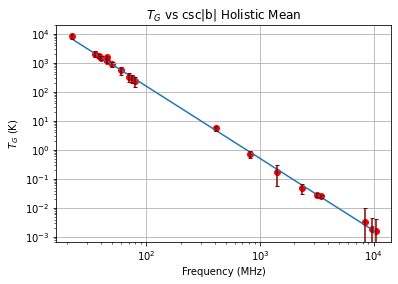

-2.4865194828822808 7.168016418251209


In [25]:
#ARCADE's vals [freq,T_G] taken from webplotdigitizer
ARCADE_values=np.array([[0.022, 7916.466442719286],[0.0449911960441924, 1477.608608244475],[0.40821171019251795, 5.423909275261779],[1.4187602660051026, 0.18211559182524475],[3.1830482133930253, 0.024842402354320066],[3.292042817918938, 0.02223972977416826],[7.944768276910435, 0.00217662549410399],[8.125112950295586, 0.0035161015953122823],[9.723324608998443, 0.0016505302870564848],[10.169769956773699, 0.001477608608244478]]).transpose()

plt.plot(freq_hol_mean,coeffs[0]*(np.array(freq_hol_mean)/310)**(coeffs[1]))    
plt.errorbar(x=freq_hol_mean,y=T_g_hol_mean,yerr=T_g_unc_hol_mean,fmt="none",color="maroon",capsize=2)
plt.scatter((freq_hol_mean),(T_g_hol_mean),color="red",alpha=0.5)
plt.scatter((ARCADE_values[0])*1000,(ARCADE_values[1]),color="cyan",alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| ARCADE Model")
plt.grid()
plt.show()
print("Beta=%.4f pm %.4f"% (coeffs[1],coeffs_err[1]),"T_gal=%.4f pm %.4f"% (coeffs[0],coeffs_err[0]))